## Import libraries

In [40]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
import pandas as pd
from pandas import DataFrame
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob

from xgboost import XGBRegressor
from xgboost import plot_importance

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import prophet
from prophet import Prophet

## Define reusable functions

#### Function for reading data from model dataset

In [2]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    return df_data

#### Function for calculating *Mean Absolute Percentage Error* and *Root Mean Squared Error*

In [3]:
# Calculate Mean Absolute Percentage Error and Root Mean Squared Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

#### Function for executing Prophet model

In [1]:
## Prophet model
def prophet_run(train_data, test_data):
    prophet_model = Prophet()
    prophet_model_fit = prophet_model.fit(train_data)
    prophet_pred = prophet_model_fit.predict(test_data)
    # summarize the forecast
    print(prophet_pred[['date', 'yhat', 'yhat_lower', 'yhat_upper']].head())
    # plot forecast
    prophet_model.plot(prophet_pred)
    plt.show()
    return prophet_pred

#### Function for reviewing results of multiple models

In [5]:
def mod_review(models, demand_name):
    plt.figure(figsize=(12,5))

    for name, y_pred in models.items():
        mape, rmse = accuracy(y_test, y_pred)
        print('================================================================')
        print(name)
        print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
        print('Root Mean Square Error : {}'.format(rmse))
    
        # Plot forecast
        plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

    plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
    plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
    plt.xlabel('Time', fontsize=10)
    plt.ylabel(demand_name, fontsize=10)
    plt.legend(loc='best')
    plt.title(f'{demand_name} Forecast', fontsize=12)
    plt.show()

#### Set python variables

In [6]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Set the period of forecast from 2010 to 2020
start_mth = datetime.datetime(2010, 1, 1)
end_mth = datetime.datetime(2020, 12, 1)

#### Read pre-processed multi-variable dataset into pandas dataframe

In [27]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

#### Prepare data for time series modelling

In [28]:
# Convert date column to datetime datatype
df_model_data['date'] = pd.to_datetime(df_model_data['date'])

# Set dataframe index to date column
df_model_data.index = df_model_data.date

# Filter records within start and end month
df_model_data = df_model_data[( df_model_data['date']>=start_mth) & (df_model_data['date'] <= end_mth)]

#### Prepare data for Prophet

In [95]:
# Set the forecast window to 24 months
forecast_mths = 24 

# Reduce dataframe to only include date and demand variables
df_model_reduced = df_model_data[['date', 'demand_avg_daily_max']]

# Change column names to those expected by Prophet
df_model_reduced.columns = ['ds', 'y']

# Create test and train subsets, where test holds all rows for the last 24 months
train = df_model_reduced[ : -forecast_mths]
test = df_model_reduced[-forecast_mths :]

y_train_prophet = train[['ds', 'y']]
y_test_prophet = DataFrame(test['ds'].reset_index(drop=True))
y_test = test['y'].reset_index(drop=True)
y_train = train['y'].reset_index(drop=True)


In [96]:
y_test

0     10830.285161
1      9289.402857
2      9042.357419
3      9134.740333
4      9675.157419
5     10156.684000
6      9978.490323
7     10022.160645
8      9121.737000
9      8818.866452
10     9118.742667
11     9565.080645
12    10149.833548
13     9311.358966
14     8817.485806
15     8982.185000
16     9679.506129
17    10175.359000
18    10394.697742
19     9764.800000
20     9027.053000
21     8757.940323
22     9291.636333
23     8608.121290
Name: y, dtype: float64

In [85]:
type(y_test)

pandas.core.series.Series

#### Run Prophet

In [97]:
prophet_model = Prophet()


In [98]:
prophet_model_fit = prophet_model.fit(y_train_prophet) 


13:51:13 - cmdstanpy - INFO - Chain [1] start processing
13:51:13 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
prophet_pred = prophet_model_fit.predict(y_test_prophet)

In [100]:

 # summarize the forecast
print(prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


          ds         yhat   yhat_lower    yhat_upper
0 2019-01-01  9779.753058  9527.776118  10032.231247
1 2019-02-01  9705.870381  9492.451445   9964.702931
2 2019-03-01  9308.200270  9068.537137   9539.667596
3 2019-04-01  9149.059105  8891.424915   9388.215098
4 2019-05-01  9781.086165  9548.350163  10007.039366


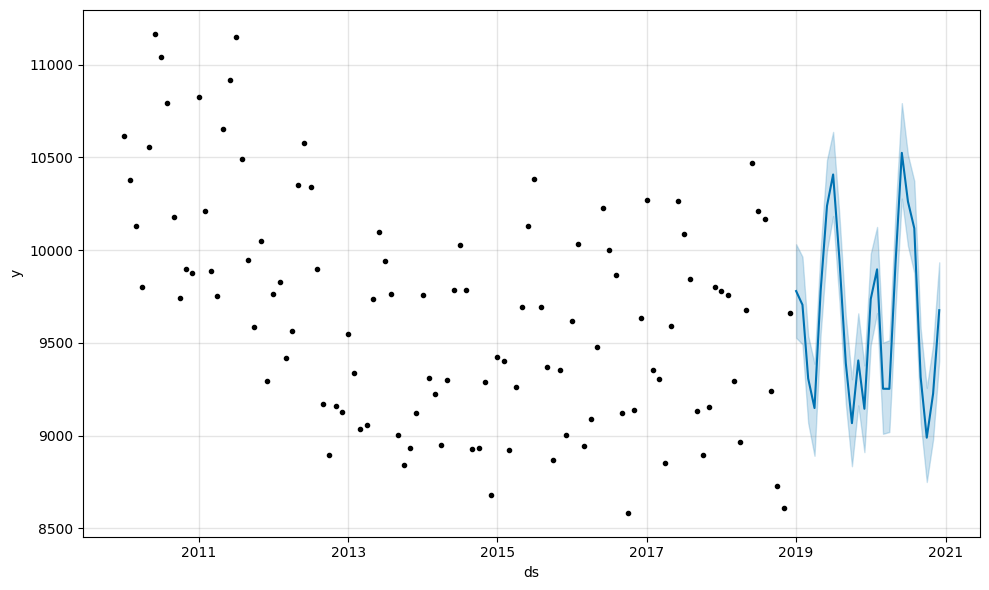

In [101]:
   # plot forecast
prophet_model.plot(prophet_pred)
plt.show()

Prophet
Mean Absolute Percentage Error (MAPE) : 3.57%
Root Mean Square Error : 424.92595524061653


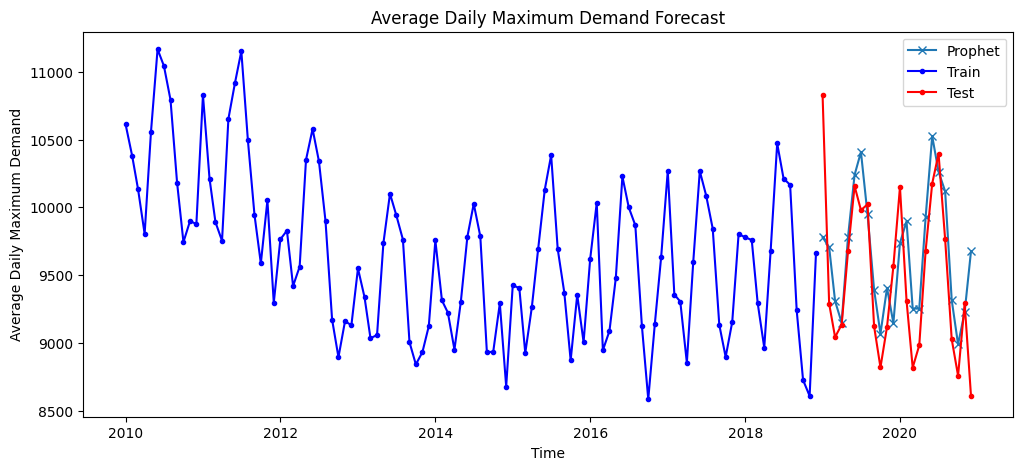

In [102]:
y_pred = prophet_pred['yhat']
models = {
    #'Holt Winter': hw_pred,
    'Prophet': y_pred
}
mod_review(models=models, demand_name='Average Daily Maximum Demand')

In [74]:
y_pred

,yhat
0,9779.753058
1,9705.870381
2,9308.200270
3,9149.059105
4,9781.086165
5,10238.891850
6,10408.222409
7,9948.133524
8,9390.951130
9,9067.442146
